In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from training import Experiment
import os
from datetime import datetime
import pickle


#dict is a dictornary with the labels you want to assign
plt.figure(figsize=(16,10)  , dpi=70)
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)
exp = Experiment(number_phases=2, layers=2, resolution=0.1, bound_displacements=1, save_tables=True)
exp.load_data("run_4",tables=True)
# run_color = tuple(np.random.randint(256, size=3)/256)


2L2PH0.1R
run_4
successfully loaded the tables :)


In [2]:
from basics import Basics
bb = Basics(resolution=exp.resolution, bound_displacements=exp.bound_displacements)
bb.define_actions()

last = exp.n_table_evolution[-1]
lastq = exp.q_table_evolution[-1]
l0most = np.where(last[0] == np.max(last[0]))[0][0]
l10most = np.where(last[1][0][l0most,:] == np.max(last[1][0][l0most,:]))[0][0]
l11most = np.where(last[1][1][l0most,:] == np.max(last[1][1][l0most,:]))[0][0]

ql0most = np.where(lastq[0] == np.max(lastq[0]))[0][0]
q10most = np.where(lastq[1][0][ql0most,:] == np.max(lastq[1][0][ql0most,:]))[0][0]
q11most = np.where(lastq[1][1][ql0most,:] == np.max(lastq[1][1][ql0most,:]))[0][0]

In [3]:
guess = exp.q_table_guess_evolution[-1]
nguess = exp.n_table_guess_evolution[-1]

In [4]:
guess.shape

(2, 2, 21, 21, 2)

In [5]:
print(nguess[0,0,l0most,l10most])
print(guess[0,0,l0most,l10most])

[48943. 48455.]
[0.63428887 0.35738314]


In [6]:
help(bb.P)

Help on method P in module basics:

P(a, b, et, n) method of basics.Basics instance
    | <eta | et* lpha >|**2
    
    Notice that the real phase is not considered here, and is multiplied externally, when the function is called, as
    P(real_phase*a, beta, et, n)...



In [7]:
pn1n2mas = bb.P(exp.amplitude, bb.actions[l0most], np.cos(bb.at[0]),0)*bb.P(exp.amplitude, bb.actions[l10most], np.sin(bb.at[0]),0)
pn1n2menos = bb.P(-exp.amplitude, bb.actions[l0most], np.cos(bb.at[0]),0)*bb.P(-exp.amplitude, bb.actions[l10most], np.sin(bb.at[0]),0)

In [8]:
norm=0

for ph in [-1,1]:
    for n1 in [0]:
        for n2 in [0]:
            norm += bb.P(ph*exp.amplitude, bb.actions[l0most], np.cos(bb.at[0]),n1)*bb.P(ph*exp.amplitude, bb.actions[l10most], np.sin(bb.at[0]),0)

In [9]:
pn1n2mas/norm

0.6377670146125947

In [10]:
l0most

2

In [11]:
def funci(beta2, sgn="plus", n1=0, n2=0):
    pn1n2mas = bb.P(exp.amplitude,bb.actions[l0most] , np.cos(bb.at[0]),n1)*bb.P(exp.amplitude, beta2, np.sin(bb.at[0]),n2)
    pn1n2menos = bb.P(-exp.amplitude,bb.actions[l0most] ,np.cos(bb.at[0]),n1)*bb.P(-exp.amplitude, beta2, np.sin(bb.at[0]),n2)
    norm=0
    for ph in [-1,1]:
        norm += bb.P(ph*exp.amplitude,bb.actions[l0most] ,np.cos(bb.at[0]),n1)*bb.P(ph*exp.amplitude, beta2, np.sin(bb.at[0]),n2)
    if sgn=="plus":
        return pn1n2mas/norm
    else:
        return pn1n2menos/norm

In [12]:
def func(beta1,beta2, sgn="plus", n1=0, n2=0):
    pn1n2mas = bb.P(exp.amplitude, beta1, np.cos(bb.at[0]),n1)*bb.P(exp.amplitude, beta2, np.sin(bb.at[0]),n2)
    pn1n2menos = bb.P(-exp.amplitude,beta1, np.cos(bb.at[0]),n1)*bb.P(-exp.amplitude, beta2, np.sin(bb.at[0]),n2)
    norm=0
    for ph in [-1,1]:
        norm += bb.P(ph*exp.amplitude,beta1, np.cos(bb.at[0]),n1)*bb.P(ph*exp.amplitude, beta2, np.sin(bb.at[0]),n2)
    if sgn=="plus":
        return pn1n2mas/norm
    else:
        return pn1n2menos/norm

In [13]:
def func0(beta1):
    p=0
    for n1 in [0,1]:
        pbeta2=[]
        for beta2 in np.arange(-1,1,.01):
            for n2 in [0,1]:
                pbeta2.append(np.max([bb.P(ph*exp.amplitude, beta1, np.cos(bb.at[0]),n1)*
                                      bb.P(ph*exp.amplitude, beta2, np.sin(bb.at[0]),n2) for ph in [-1,1]]))
        p+=max(pbeta2)
    return p/2

In [14]:
def func0prima(beta1):
    p=0
    for n1 in [0,1]:
        pbeta2=[]
        for beta2 in np.arange(-1,1,.01):
            minip=0
            for n2 in [0,1]:
                minip +=np.max([bb.P(ph*exp.amplitude, beta1, np.cos(bb.at[0]), n1)*
                                bb.P(ph*exp.amplitude, beta2, np.sin(bb.at[0]), n2) for ph in [-1,1]])
            pbeta2.append(minip)
        p+=np.max(pbeta2)#*np.sum([/2 for ph in [-1,1]])
    return p/2

In [15]:
def final_q_value(beta1):
    p=0
    for n1 in [0,1]:
        pbeta2=[]
        for beta2 in bb.actions:
            minip=0
            for n2 in [0,1]:
                minip +=np.max([bb.P(ph*exp.amplitude, beta1, np.cos(bb.at[0]), n1)*
                                bb.P(ph*exp.amplitude, beta2, np.sin(bb.at[0]), n2) for ph in [-1,1]])
            pbeta2.append(minip)
        p+=np.max(pbeta2)#*np.sum([/2 for ph in [-1,1]])
    return p/2

In [16]:
np.sort([final_q_value(vv) for vv in bb.actions])

array([0.72983491, 0.74716329, 0.74716329, 0.76836831, 0.76836831,
       0.78873531, 0.78873531, 0.80402516, 0.80402516, 0.80790747,
       0.80790747, 0.8147714 , 0.8147714 , 0.81478607, 0.81478607,
       0.8201926 , 0.8201926 , 0.82120924, 0.82120924, 0.82321755,
       0.82321755])

In [17]:
np.sort([func0prima(vv) for vv in bb.actions])

array([0.73014025, 0.74732332, 0.74732332, 0.76907511, 0.76907511,
       0.78877411, 0.78877411, 0.80449447, 0.80449447, 0.8080651 ,
       0.8080651 , 0.81550208, 0.81550208, 0.81566538, 0.81566538,
       0.8210474 , 0.8210474 , 0.82168811, 0.82168811, 0.82331731,
       0.82331731])

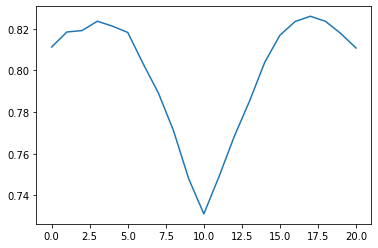

In [18]:
plt.plot(lastq[0])

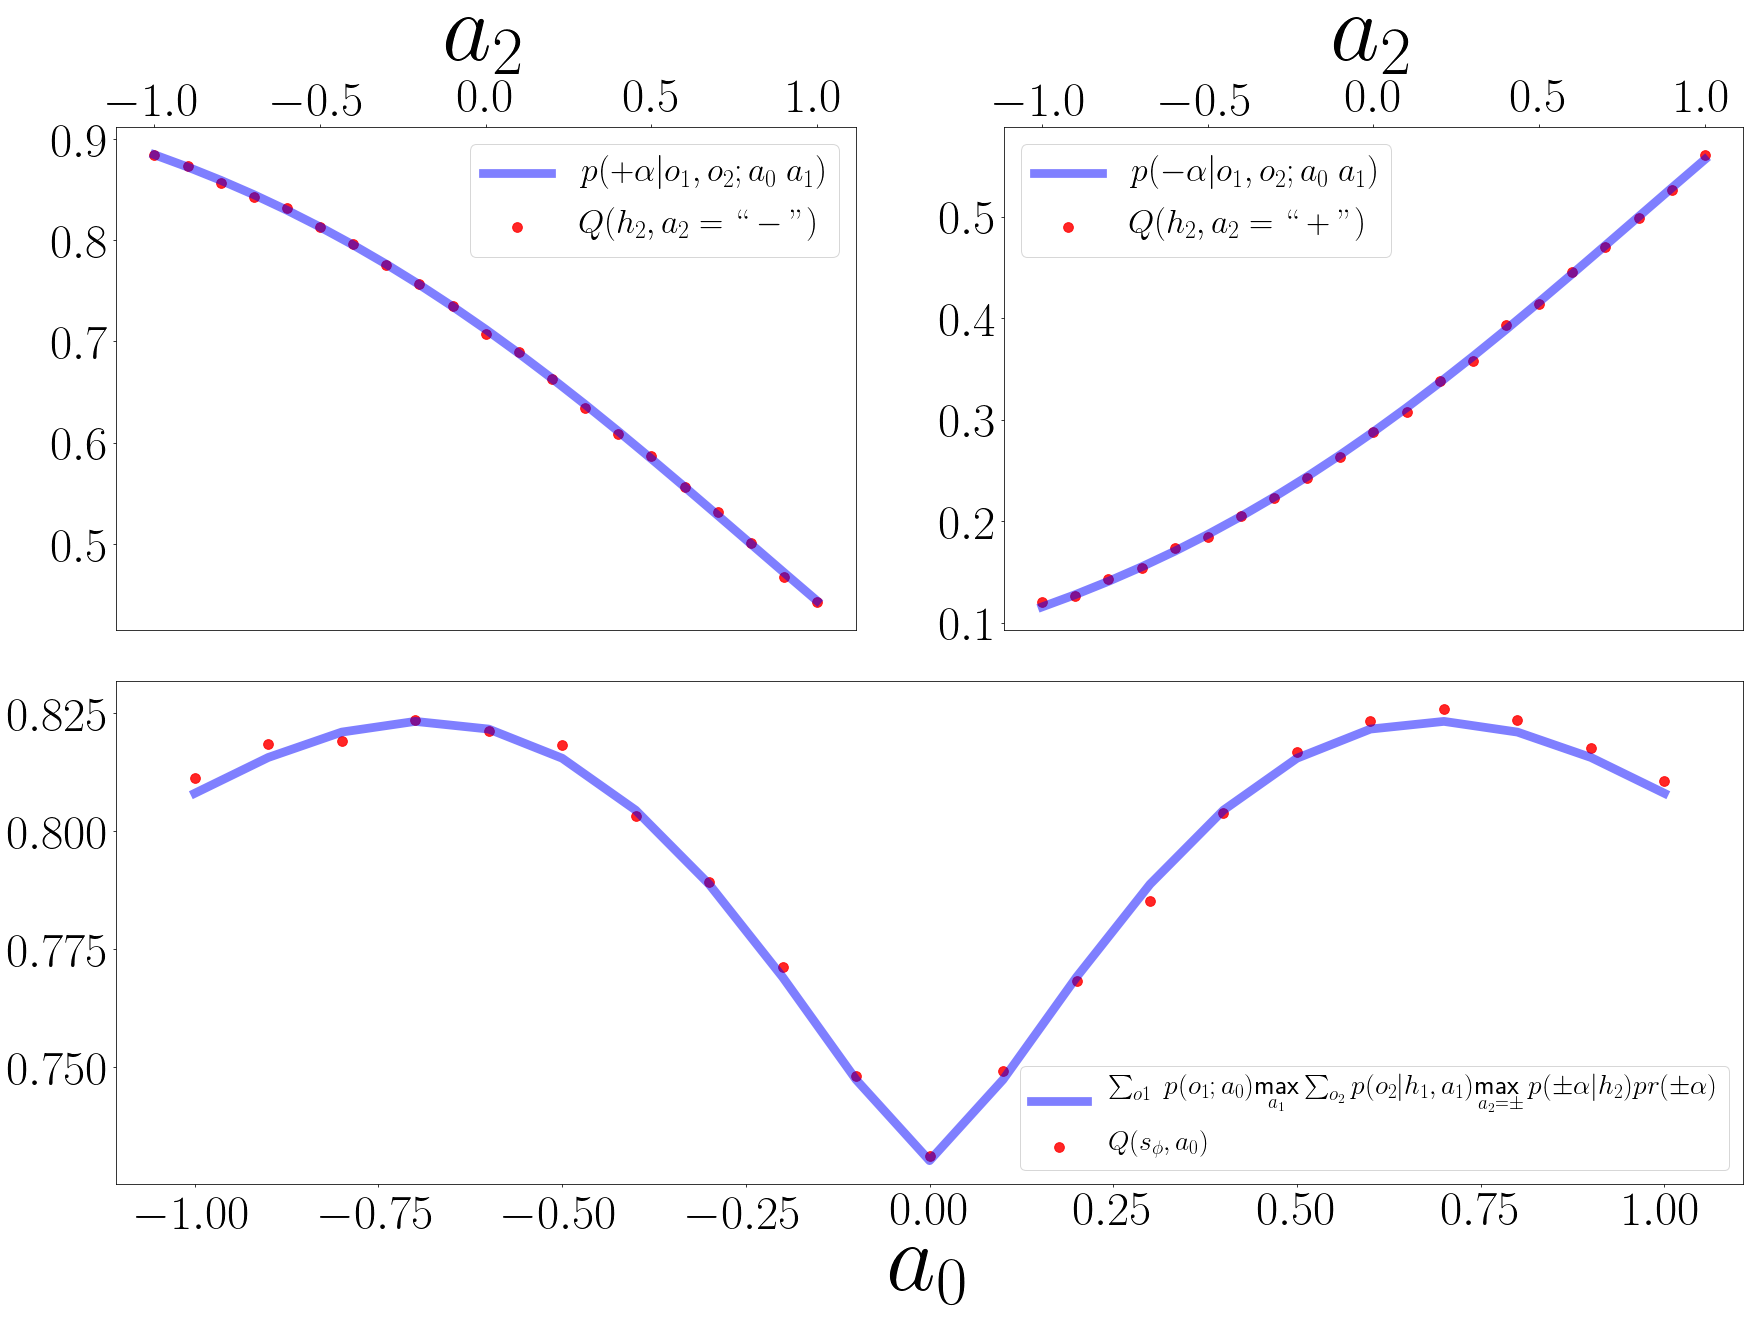

In [30]:
import matplotlib
matplotlib.rc('font', serif='cm10')
matplotlib.rc('text', usetex=True)
axinticks=[]
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

plt.rcParams.update({'font.size': 50})

plt.figure(figsize=(30,20)  , dpi=70)
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2),(1,0), colspan=2)

labelci = r'$\sum_{o1}\;p(o_1; a_0) \underset{a_1}{\text{max}} \sum_{o_2} p(o_2|h_1, a_1) \underset{a_2 = \pm}{\text{max }} p(\pm \alpha | h_2) pr(\pm \alpha)$'

ax1.plot(bb.actions,funci(bb.actions,sgn="plus"), '-',linewidth=9, alpha=0.5, color="blue",label=r'$p(+\alpha|o_1, o_2; a_0 \; a_1) $')
ax2.plot(bb.actions,funci(bb.actions,sgn="minus"), '-',linewidth=9, alpha=0.5, color="blue",label=r'$p(-\alpha|o_1, o_2; a_0 \; a_1) $')
ax3.plot(bb.actions,[func0prima(vv) for vv in bb.actions], '-',linewidth=9, alpha=0.5,
         color="blue",label=labelci)
ax1.scatter(bb.actions,guess[0,0,l0most,:,0],s=100,alpha=0.85,color="red",label=r'$Q(h_2, a_2=``-")$')
ax2.scatter(bb.actions,guess[0,0,l0most,:,1],s=100,alpha=0.85,color="red", label=r'$Q(h_2, a_2=``+")$')
ax3.scatter(bb.actions,lastq[0],s=100,alpha=0.85,color="red", label=r'$Q(s_{\phi},a_0)$')

ax1.legend(prop={"size":35})
ax2.legend(prop={"size":35})
ax3.legend(prop={"size":28.5}, loc="lower right")

plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
ax2.set_xlabel(r'$a_2$',size=100)
ax1.set_xlabel(r'$a_2$',size=100)
ax3.set_xlabel(r'$a_0$',size=100)
ax1.xaxis.set_ticks_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax1.xaxis.set_label_position('top') 
ax2.xaxis.set_label_position('top') 

#ax1.set_ylabel("Q(h_2,a(h_2)=+)")
#ax2.set_ylabel("Q(h_2,a(h_2)=+)")
plt.savefig("qprofguess108.pdf")

In [90]:
import os

In [32]:
os.getcwd()

'/home/cooper-cooper/Desktop/versions/appendixA'

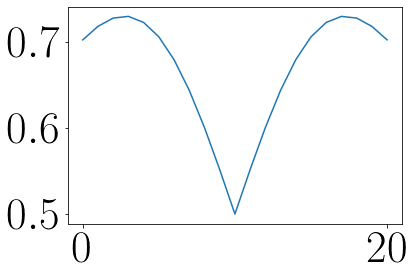

In [19]:
plt.plot([func0(b) for b in bb.actions])

In [43]:
np.save("100000_guess_qtable_1greedy",last, allow_pickle=True)
np.save("100000_disp_qtable_1greedy",last, allow_pickle=True)